In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier, IsolationForest
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, KFold

import catboost

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
file = 'train.csv'

df = pd.read_csv(file)

df.head()

,uid,home_team,sz_top,sz_bot,pitch_type,release_pos_x,release_pos_y,release_pos_z,stand,p_throws,...,release_spin_rate,pfx_x,pfx_z,plate_x,plate_z,hc_x,hc_y,launch_speed,launch_angle,is_hr
0,0,LAA,3.35,1.61,CU,-2.14,53.69,6.48,R,R,...,2110,0.73,-0.79,-0.11,3.19,138.97,86.01,94.6,47,0
1,2,LAA,3.39,1.63,CH,1.83,54.15,5.94,R,L,...,1710,1.22,0.71,0.74,1.44,111.73,159.90,69.5,-30,0
2,4,LAA,3.46,1.59,CU,-2.32,53.99,6.43,L,R,...,2154,0.73,-0.67,-0.32,2.69,112.87,148.15,93.8,66,0
3,5,LAA,3.29,1.54,SL,-2.01,53.71,6.37,R,R,...,2209,0.50,0.98,-0.20,2.14,180.78,96.91,87.5,38,0
4,6,LAA,3.47,1.65,FF,-2.16,53.61,6.29,L,R,...,2230,-0.29,1.60,0.00,2.89,134.75,101.76,100.0,-2,0


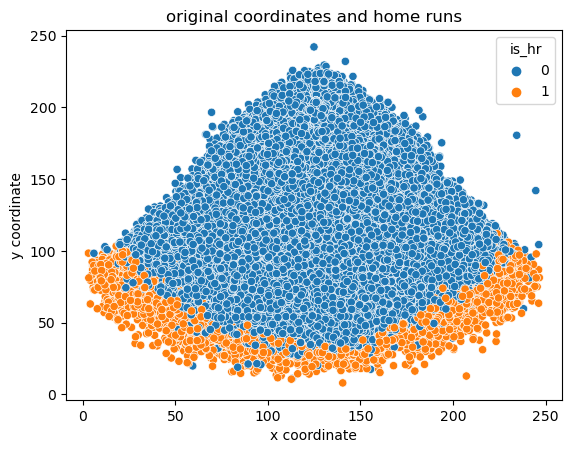

In [3]:
# since we have actual ball coordinates, let's plot them
# the plot is nice, but the coordinates not
fig, ax = plt.subplots()

sns.scatterplot(x=df['hc_x'], y=df['hc_y'], hue=df['is_hr'])
plt.title("original coordinates and home runs")

ax.set_xlabel("x coordinate")
ax.set_ylabel("y coordinate")

plt.show()

In [4]:
# scaling and flipping x and y so they're more intelligible
df['hc_x_centered'] = (df['hc_x'] - 125)
df['hc_y_flipped'] = (199 - df['hc_y'])
df['implied_distance'] = np.sqrt(df['hc_x_centered'] ** 2 + df['hc_y_flipped'] ** 2)

# calculating radians from the new origin - home runs are a 
# function of distance, angle, and park for sure
df['angle_radians'] = np.arctan(df['hc_x_centered'] / df['hc_y_flipped'])

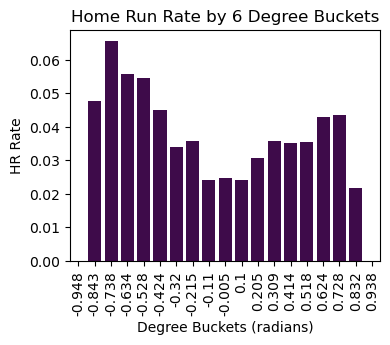

In [5]:
# looking at another notebook, dividing the 'spray angle'
# into buckets looks like a neat idea

# converting degrees to radians for plot
DEGREE_OF_INTEREST = 6

radians = DEGREE_OF_INTEREST * (np.pi / 180)

# examining home run rate by radian bucket
radian_buckets = (
    df
    .groupby(pd.cut(df['angle_radians'], bins=np.arange(-1, 1, radians)))['is_hr']
    .mean()
    .reset_index()
)

radian_buckets.columns = ['bin_bucket', 'hr_rate']
radian_buckets['bin_bucket_median'] = radian_buckets['bin_bucket'].apply(lambda x: round(x.mid, 3))

fig, ax = plt.subplots(figsize=(4,3))

sns.barplot(data=radian_buckets, x='bin_bucket_median', y='hr_rate', ax=ax, color='#440154')

plt.title(f"Home Run Rate by {DEGREE_OF_INTEREST} Degree Buckets")
plt.ylabel("HR Rate")
plt.xlabel("Degree Buckets (radians)")
plt.xticks(rotation=90)
plt.show()

In [6]:
# now i'm going to copy what was done and create factors that
# combine home_field and degree bucket

radians_model = 4 * (np.pi / 180)

df['radian_bucket'] = (
    pd.cut(df['angle_radians'], bins=np.arange(-1, 1, radians_model))
)

df['home_field_radian_bucket'] = df['home_team'] + '_' + df['radian_bucket'].astype(str)
df.drop(columns='radian_bucket', inplace=True)

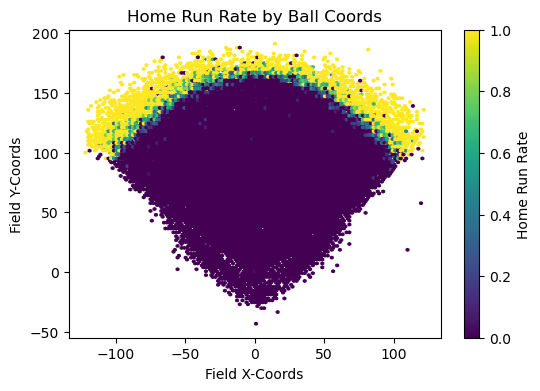

In [7]:
fig, ax = plt.subplots(figsize=(6,4))
plt.hexbin(df['hc_x_centered'],
           df['hc_y_flipped'],
           C=df['is_hr'],
           gridsize=125,
           cmap='viridis',
           reduce_C_function=np.mean)

cb = plt.colorbar(label='Home Run Rate')

plt.title("Home Run Rate by Ball Coords")
plt.xlabel("Field X-Coords")
plt.ylabel("Field Y-Coords")
plt.show()

In [8]:
# sorting home runs by distance. clearly uid 37812 is unusual and
# out side of the distribution for the others

df[df['is_hr'] == 1][['uid', 'implied_distance']].sort_values(by='implied_distance').head(10)

,uid,implied_distance
31464,37812,1.563106
46945,56505,111.102105
32569,39151,111.486538
12201,14625,112.643136
53558,64488,116.229060
4465,5342,117.936078
70557,84930,126.360004
69339,83478,128.036497
32585,39171,128.394804
23330,27976,128.561974


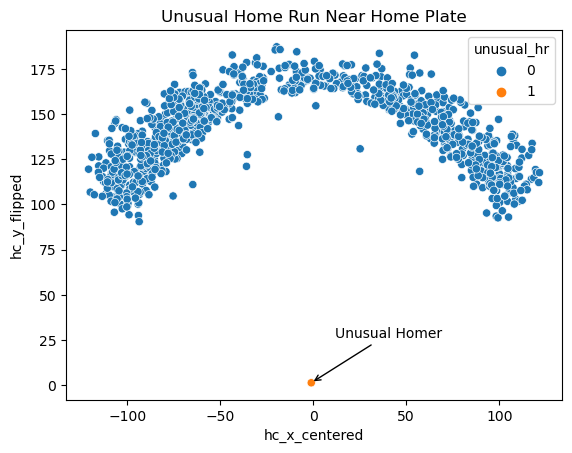

In [9]:
# plotting the unusual home run just as an exercise
sample_df = df[df['is_hr'] == 1].sample(1000).copy()
unusual_hr = df[df['uid'] == 37812].copy()
sample_df = pd.concat([sample_df, unusual_hr])
sample_df['unusual_hr'] = np.where(sample_df['uid'] == 37812, 1, 0)

sns.scatterplot(x='hc_x_centered', y='hc_y_flipped', data=sample_df, hue='unusual_hr')

highlight_point = sample_df[sample_df['uid'] == 37812].iloc[0]
arrow_text = "Unusual Homer"
plt.annotate(arrow_text, xy=(highlight_point['hc_x_centered'], highlight_point['hc_y_flipped']),
             xytext=(highlight_point['hc_x_centered'] + 13, highlight_point['hc_y_flipped'] +25),
             arrowprops=dict(facecolor='red', arrowstyle='->'))

plt.title("Unusual Home Run Near Home Plate")
plt.show()

In [10]:
# dropping the row with the unusual home run
df = df[df['uid'] != 37812].copy()

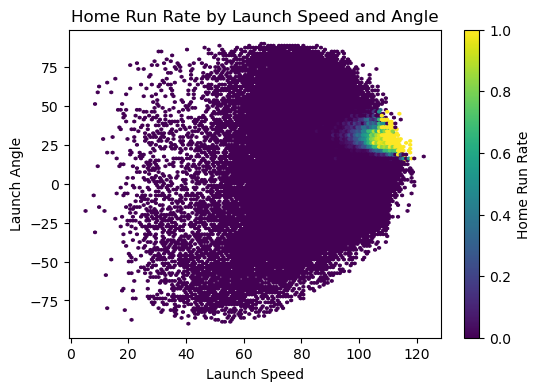

In [11]:
# creating a two-dimensional hexbin plot displaying
# home run probability given launch speed and angle.
# it looks like outside of a narrow wedge the probability
# drops to zero.

fig, ax = plt.subplots(figsize=(6,4))
plt.hexbin(df['launch_speed'],
           df['launch_angle'],
           C=df['is_hr'],
           gridsize=125,
           cmap='viridis',
           reduce_C_function=np.mean)

cb = plt.colorbar(label='Home Run Rate')

plt.title("Home Run Rate by Launch Speed and Angle")
plt.xlabel("Launch Speed")
plt.ylabel("Launch Angle")
plt.show()

In [23]:
# given the plot above, its probably best to restrict
# the training set to only launch angles and speeds
# with a hr probability greater than 0

launch_angle_max = df[df['is_hr']==1]['launch_angle'].max()
launch_angle_min = df[df['is_hr'] ==1]['launch_angle'].min()
launch_speed_min = df[df['is_hr'] == 1]['launch_speed'].min()

train_condition = (
    (df['launch_angle'].between(launch_angle_min, launch_angle_max)) & \
    (df['launch_speed'] >= launch_speed_min)
)

# our new training set
train_df = df[train_condition].copy()
train_df.reset_index(drop=True, inplace=True)

print("we have retained", round(len(train_df) / len(df), 4),"of original df")

we have retained 0.3002 of original df


In [14]:
# training an untuned catboost model
X = train_df.drop(columns=['uid', 'is_hr', 'inning_topbot', 'on_1b', 
                           'p_throws', 'pfx_x', 'stand', 'release_pos_y', 
                           'release_pos_x', 'spin_axis', 'outs_when_up',
                           'release_speed', 'if_fielding_alignment',
                           'of_fielding_alignment'])
y = train_df['is_hr']

categorical_columns = X.select_dtypes(exclude=['float', 'int']).columns.to_list()

kf = KFold(n_splits=10, shuffle=True)

oof = np.zeros(len(X))

for train, val in kf.split(X, y):
    
    train_x = X.iloc[train]
    train_y = y[train]
    
    val_x = X.iloc[val]
    val_y = y[val
             ]

    model = catboost.CatBoostClassifier(cat_features=categorical_columns)
    
    model.fit(train_x, train_y, eval_set=(val_x, val_y), early_stopping_rounds=10, verbose=False)
    
    preds = model.predict_proba(val_x)[:,1]
    
    oof[val] = preds
    
print("the log loss on the out of fold preds is:", log_loss(y, oof))

the log loss on the out of fold preds is: 0.06498525605290961


In [15]:
# training an untuned model on all of the data

features = X.columns

final_model = catboost.CatBoostClassifier(
    iterations=228, 
    cat_features=categorical_columns,
    verbose=0
)

final_model.fit(X, y)

In [17]:
# loading the test data and engineering the features
test_file = 'test.csv'

test_df = pd.read_csv(test_file)

test_df['hc_x_centered'] = (test_df['hc_x'] - 125)
test_df['hc_y_flipped'] = (199 - test_df['hc_y'])
test_df['implied_distance'] = np.sqrt(test_df['hc_x_centered'] ** 2 + test_df['hc_y_flipped'] ** 2)

# calculating radians from the new origin - home runs are a 
# function of distance, angle, and park for sure
test_df['angle_radians'] = np.arctan(test_df['hc_x_centered'] / test_df['hc_y_flipped'])

# creating the radian bucket feature
test_df['radian_bucket'] = (
    pd.cut(test_df['angle_radians'], bins=np.arange(-1, 1, radians_model))
)

test_df['home_field_radian_bucket'] = test_df['home_team'] + '_' + test_df['radian_bucket'].astype(str)
test_df.drop(columns='radian_bucket', inplace=True)

In [18]:
# using the same min and max to select the subset of
# the test df we'll predict on
launch_angle_max = df[df['is_hr']==1]['launch_angle'].max()
launch_angle_min = df[df['is_hr'] ==1]['launch_angle'].min()
launch_speed_min = df[df['is_hr'] == 1]['launch_speed'].min()

test_condition = (
    (test_df['launch_angle'].between(launch_angle_min, launch_angle_max)) & \
    (test_df['launch_speed'] >= launch_speed_min)
)

# assigning a default value of 0.00001 to avoid infinite loss
test_df['is_hr'] = 0.00001

# getting predictions for qualifying rows
test_df.loc[test_condition, 'is_hr'] = (
    final_model.predict_proba(test_df[test_condition][features])[:,1]
)

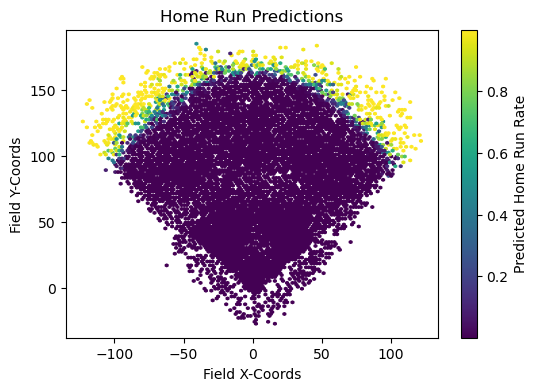

In [22]:
# plotting the predicted home run coordinates
# looks pretty good to me
plt.hexbin(test_df['hc_x_centered'],
           test_df['hc_y_flipped'],
           C=test_df['is_hr'],
           gridsize=125,
           cmap='viridis',
           reduce_C_function=np.mean)

cb = plt.colorbar(label='Predicted Home Run Rate')

plt.title("Home Run Predictions")
plt.xlabel("Field X-Coords")
plt.ylabel("Field Y-Coords")
plt.show()

In [20]:
print("home run percentage on train set:", df['is_hr'].mean())
print("home run percentage on test:", test_df['is_hr'].mean())

home run percentage on train set: 0.037335059810087556
home run percentage on test: 0.03801888305027063


In [21]:
# creating submission df
submission = test_df[['uid', 'is_hr']].copy()

submission.head()

,uid,is_hr
0,100541,0.00001
1,18420,0.00001
2,29296,0.00001
3,18753,0.00001
4,72142,0.00001


In [90]:
submission.to_csv('try_again_0718.csv', index=False)